<a href="https://colab.research.google.com/github/Dforouzanfar/ML_Unimi_2024/blob/master/Muffin_vs_chihuahua_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. preliminary setup

## 0.1. Importing the required libraries

Computer vision libaries in PyTorch:
* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.transforms` - functions for manipulating your images to be suitable for use with an ML model
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import os
from google.colab import files
import random
import zipfile
import requests
from pathlib import Path
from typing import Tuple, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import itertools

## 0.2. Setup device-agnostic code

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sat May 25 03:31:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 0.3. Make a path for:
* Data
* Models
* Results
* Confusion Matrix

In [3]:
# 1. Create data directory
data_path = Path("data/")
image_path = data_path / "muffin_chihuahua"

# 2. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 3. Create resualts directory
results_PATH = Path("results")
results_PATH.mkdir(parents=True, exist_ok=True)

# 4. Create pics directory
pic_PATH = Path("pics")
pic_PATH.mkdir(parents=True, exist_ok=True)

## 0.4. Loading the models
If you want to load the trained models, set `loaded_model` to `True`.

In [4]:
# Load the models
loaded_model = False

if loaded_model:
  target_folder = '/content/models'
  # Upload the files
  uploaded = files.upload()

  # Move each uploaded file to the target folder
  for filename in uploaded.keys():
    dest_path = os.path.join(target_folder, filename)
    os.rename(filename, dest_path)

## 0.5. Helper functions
* walk_through_dir - It gives us the number of directories and images in a path
* ImageFolder_data - load image classification data
* create_dataloader - Turn the imagefolder to dataloader to set batch size
* zero_one_loss_fn - To compute the zero one loss
* SaveModel - To save the models that we trained
* loadModel - To load the trained models
* train_fn - train function that takes in various model's parameters, optimizer, dataloaders, and loss function. The output of this function wold be the trained model and a dictionary with the results.
* test_fn - test function that use the model on testing image to predict the labels of them and it's outputs are the predictions, real labels, and a dictionary containing the results of the test.
* plot_confusion_matrix - to make a confusion matrix
* test_ReportResults - to make a report of the testing part

In [5]:
# using os.walk, help us to find out about three things: directory path, directory name, the name of a file
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
def ImageFolder_data(transform, dir):
  ImageFolder = datasets.ImageFolder(root=dir, transform=transform)

  return ImageFolder

In [7]:
def create_dataloader(dataset, indices, BATCH_SIZE=32, NUM_WORKERS=None):
  if NUM_WORKERS is None:
    NUM_WORKERS = torch.cuda.device_count() if torch.cuda.is_available() else os.cpu_count()

  subset = Subset(dataset, indices)
  dataloader = DataLoader(dataset=subset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
  return dataloader

In [8]:
def zero_one_loss_fn(output, target):
  loss = (output != target).to(torch.float32).mean()
  return loss

In [9]:
def SaveModel(model, name):
  F = MODEL_PATH/name
  torch.save(obj=model, f=f"{F}.pt")
  # files.download(f"{F}.pt")
  print(f"Saving: {name}")

In [10]:
def loadModel(name):
  F = MODEL_PATH/name
  model = torch.load(f=f"{F}.pt")
  model.to(device)
  model.eval()
  print(f"Loading: {name}")
  return model

In [11]:
def train_fn(model,
             train_dataloader,
             test_dataloader,
             fold_num,
             model_type,
             optimizer,
             learning_rate,
             results_dict: Dict,
             num_epochs = 40,
             writer = None,
             loss_fn = nn.BCEWithLogitsLoss()):

  # Train the model
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(num_epochs)):

    # Put the model in train mode
    model.train()

    # Setup some variables
    train_acc, train_loss, train_ZOL = 0, 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(train_dataloader):

      # Send data to the target device
      X, y = X.to(device), y.to(device).to(torch.float64)

      # 1. Forward pass
      y_logits = model(X).squeeze().to(torch.float64)
      y_pred_class = torch.round(torch.sigmoid(y_logits)) # We need to apply sigmoid and then round to convert logits to 0/1

      # 2. Calculate the loss
      loss = loss_fn(y_logits, y)
      loss_zero_one = zero_one_loss_fn(y_pred_class, y)

      train_loss += loss
      train_ZOL += loss_zero_one

      train_acc += (y_pred_class==y).sum().item()/len(y_pred_class)

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_acc = (train_acc / len(train_dataloader)) * 100
    train_loss /= len(train_dataloader)
    train_ZOL /= len(train_dataloader)

    # Print out what's happening
    print(f'Train:\nEpoch: ({epoch+1}) | Accuracy: {train_acc:.3f}% | Zero one Loss: {train_ZOL.item():.4f} | Entropy Loss: {train_loss.item():.4f}')

    # Update results dictionary
    results_dict[f'trainloss_{epoch+1}_{model_type}_{learning_rate}'] = train_loss.item()
    results_dict[f'trainZOL_{epoch+1}_{model_type}_{learning_rate}'] = train_ZOL.item()
    results_dict[f'trainacc_{epoch+1}_{model_type}_{learning_rate}'] = train_acc

    # Test steps
    # Put model in eval mode
    model.eval()
    test_acc, test_loss, test_ZOL = 0, 0, 0

    with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(test_dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device).to(torch.float64)

        # 1. Forward pass
        test_pred_logits = model(X).squeeze().to(torch.float64)
        test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))

        # 2. Calculate the loss
        test_loss += loss_fn(test_pred_logits, y)
        test_ZOL += zero_one_loss_fn(test_pred_labels, y)

        test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

      # Adjust metrics
      test_acc = (test_acc / len(test_dataloader)) * 100
      test_loss /= len(test_dataloader)
      test_ZOL /= len(test_dataloader)

      print(f'Test:\nEpoch: ({epoch+1}) | Accuracy:: {test_acc:.3f}% | Zero one Loss: {test_ZOL.item():.4f} | Entropy Loss: {test_loss.item():.4f}')

      # Update results dictionary
      results_dict[f'testloss_{epoch+1}_{model_type}_{learning_rate}'] = test_loss.item()
      results_dict[f'testZOL_{epoch+1}_{model_type}_{learning_rate}'] = test_ZOL.item()
      results_dict[f'testacc_{epoch+1}_{model_type}_{learning_rate}'] = test_acc

    if writer:
      writer.add_scalars(f'{model_type}/{optimizer}LR_{learning_rate}/Fold{fold_num}/Loss', {'train':train_loss, 'test':test_loss} , epoch)
      writer.add_scalars(f'{model_type}/{optimizer}/LR_{learning_rate}/Fold{fold_num}/ZeroOneLoss', {'train':train_ZOL, 'test':test_ZOL} , epoch)
      writer.add_scalars(f'{model_type}/{optimizer}/LR_{learning_rate}/Fold{fold_num}/Accuracy', {'train':train_acc, 'test':test_acc} , epoch)

  return model, results_dict

In [12]:
def test_fn(model, model_type, test_dataloader, loss_fn, results_dict: Dict):

  # Set the model to evaluation mode
  model.eval()

  y_preds = []
  y_tests = []
  test_acc, test_loss, test_ZOL = 0, 0, 0

  with torch.inference_mode():
    for X, y in test_dataloader:
      # Move data to the target device
      X, y = X.to(device), y.to(device).to(torch.float32)

      # Forward pass
      y_logits = model(X).squeeze().to(torch.float64)
      y_pred_class = torch.round(torch.sigmoid(y_logits))
      y_preds.extend(y_pred_class.cpu().numpy())
      y_tests.extend(y.cpu().numpy())

      # Calculate losses
      test_loss = loss_fn(y_logits, y).item()
      test_ZOL = zero_one_loss_fn(y_pred_class, y).item()
      test_acc = (y_pred_class==y).sum().item()/len(y_pred_class) * 100

      results_dict[f'testloss_{model_type}_{learning_rate}'] = test_loss
      results_dict[f'testZOL_{model_type}_{learning_rate}'] = test_ZOL
      results_dict[f'testacc_{model_type}_{learning_rate}'] = test_acc

    print(f'Accuracy: {test_acc:.3f}% | Zero one Loss: {test_ZOL:.4f} | Entropy Loss: {test_loss:.4f}')

    return y_preds, y_tests, results_dict

In [16]:
%matplotlib inline

def plot_confusion_matrix(cm, classes, pic_path, title='', cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(pic_path)
  plt.tight_layout()

In [17]:
def test_ReportResults(y_preds, y_tests, pic_path, cnf_plot=False):
  classesRes = [0, 1]
  cnf_matrix_Res = confusion_matrix(y_tests, y_preds, labels=classesRes)
  if cnf_plot:
    plt.figure()
    plot_confusion_matrix(cm=cnf_matrix_Res, pic_path=pic_path, classes=classesRes, title='confusion matrix')
    plt.show()
    plt.tight_layout()
    plt.close()

# 1. Get the data

In this step, we download the dataset required for our binary classification problem.  
We set the necessary variables and use the `os`, `pathlib`, `requests`, and `zipfile` libraries to read the dataset.  
We are working on a binary classification problem where we aim to distinguish between images of chihuahuas and muffins.


In [ ]:
# If you want to download the dataset, you should insert your own credentials.

os.environ['KAGGLE_USERNAME'] = "**"
os.environ['KAGGLE_KEY'] = "**"

In [18]:
# If the image folder doesn't exist, download it and prepare it...
if not image_path.is_dir():
    image_path.mkdir(parents=True, exist_ok=True)

    # Download dataset
    os.chdir(data_path)
    !kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

    os.chdir("/content/")
    with zipfile.ZipFile("/content/data/muffin-vs-chihuahua-image-classification.zip", "r") as zip_ref:
        print("Unzipping")
        zip_ref.extractall(image_path)

    # Setup training and testing paths
    train_dir = image_path / "train"
    test_dir = image_path / "test"
    print(f"{train_dir} \n{test_dir}")

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
 99% 468M/474M [00:05<00:00, 28.1MB/s]
100% 474M/474M [00:05<00:00, 87.3MB/s]
Unzipping
data/muffin_chihuahua/train 
data/muffin_chihuahua/test


# 2. data exploration and data preparation

In [19]:
# Explore the directories
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/muffin_chihuahua'.
There are 2 directories and 0 images in 'data/muffin_chihuahua/train'.
There are 0 directories and 2559 images in 'data/muffin_chihuahua/train/chihuahua'.
There are 0 directories and 2174 images in 'data/muffin_chihuahua/train/muffin'.
There are 2 directories and 0 images in 'data/muffin_chihuahua/test'.
There are 0 directories and 640 images in 'data/muffin_chihuahua/test/chihuahua'.
There are 0 directories and 544 images in 'data/muffin_chihuahua/test/muffin'.


## 2.1. Visualizing
1. First we want to get the paths for all of the images
2. Choose four images of chihuahua and four images of cookies randomly.
3. Find out the images class name
4. Open and show the chosen images
5. Print the metadata

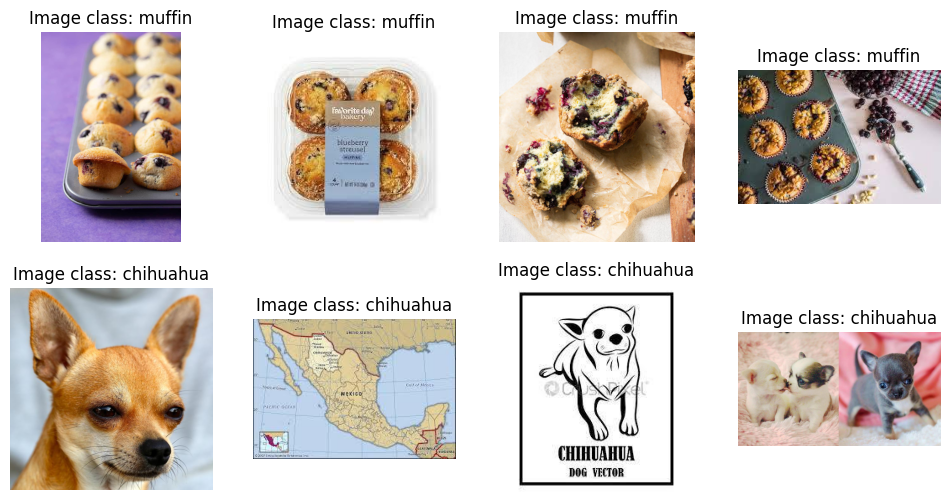

In [20]:
# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
muffin_path_list = list(image_path.glob("train/muffin/*.jpg"))
chihuahua_path_list = list(image_path.glob("train/chihuahua/*.jpg"))

# 2. Pick k random image paths
random_muffin_paths = random.sample(muffin_path_list, k=4)
random_chihuahua_paths = random.sample(chihuahua_path_list, k=4)
random_image_paths = random_muffin_paths + random_chihuahua_paths

# 3. Define the class of each image
image_class = []
for i in random_image_paths:
  image_class.append(i.parent.stem)

# 4. read the images into a list.
images = [mpimg.imread(img_path) for img_path in random_image_paths]

# 5. Create a figure with 2x4 subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through images and their respective axes
for ax, img, img_class in zip(axs, images, image_class):
  ax.imshow(img)
  ax.set_title(f"Image class: {img_class}")  # Set the title for each subplot
  ax.axis('off')  # Hide axes ticks

## 2.2. Transforming data
Before we can use our image data with PyTorch we have to turn our data into tensors. We will do this with `torchvision.transforms`.
Transforms help us get the images ready to be used with a model/perform data augmentation.




In [21]:
data_transform = transforms.Compose([
  # Resize our images to 120*120
  transforms.Resize(size=(120, 120)),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [22]:
# Checking the output for a random image that we choose before
img = random_image_paths[2]
random_img = Image.open(img)
print(f"{data_transform(random_img).shape} -> [number of color_channels, height, width]")

torch.Size([3, 120, 120]) -> [number of color_channels, height, width]


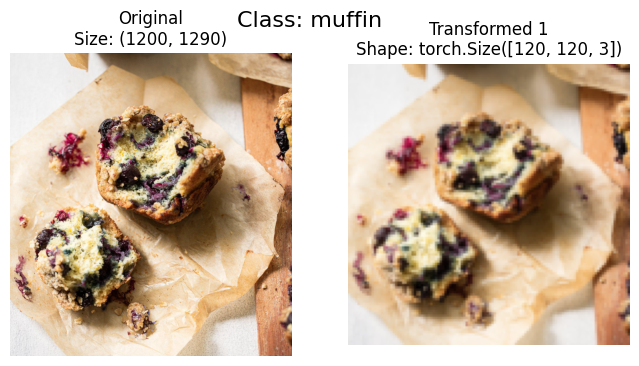

In [23]:
with Image.open(img) as f:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
  ax[0].imshow(f)
  ax[0].set_title(f"Original\nSize: {f.size}")
  ax[0].axis(False)

  # Transform and plot target image
  transformed_image = data_transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
  ax[1].imshow(transformed_image)
  ax[1].set_title(f"Transformed 1\nShape: {transformed_image.shape}")
  ax[1].axis("off")

  fig.suptitle(f"Class: {image_class[2]}", fontsize=16)

## 2.3. Loading image data

Now we have to turn the tensors into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

We would load image classification data using `torchvision.datasets.ImageFolder`.

In [24]:
train_data = ImageFolder_data(data_transform, train_dir)
test_data = ImageFolder_data(data_transform, test_dir)

In [25]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Tensor of the image:\n{img} \n\nThe shape of the tensor: {img.shape} \nThe label of the image: {label}")

Tensor of the image:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7490, 0.7569, 0.7922,  ..., 1.0000, 1.0000, 1.0000],
         [0.7961, 0.7961, 0.8000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9647, 0.9608, 0.9529,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7490, 0.7569, 0.7922,  ..., 1.0000, 1.0000, 1.0000],
         [0.7961, 0.7961, 0.8000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9647, 0.9608, 0.9529,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..

In [26]:
# Get class names as list
class_names = train_data.classes
class_names

['chihuahua', 'muffin']

In [27]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'chihuahua': 0, 'muffin': 1}

In [28]:
# Check the lengths of our dataset
print(f"number of training data: {len(train_data)} \nnumber of the test data: {len(test_data)}")

number of training data: 4733 
number of the test data: 1184


In [29]:
# with using `samples` we get two value, the path of the image and the target value (In our case we get the values for the first image in train_data)
print(f"path: {train_data.samples[0][0]} \nlabel: {train_data.samples[0][1]}")

path: data/muffin_chihuahua/train/chihuahua/img_0_0.jpg 
label: 0


Text(0.5, 1.0, 'Class: chihuahua\nshape: torch.Size([120, 120, 3])')

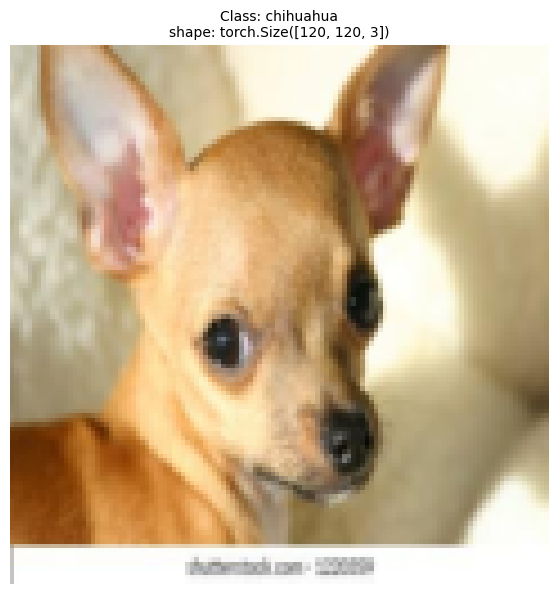

In [30]:
# set seed
random.seed(42)

# 1. Get random sample indexes
random_samples_idx = random.choice(range(len(train_data)))

img, label = train_data[random_samples_idx][0], train_data[random_samples_idx][1]

# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Class: {class_names[label]}\nshape: {img_permute.shape}", fontsize=10)

## 2.4. Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [31]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [32]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 120, 120]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


# 3. Architecture

## 3.1. TinyVGG

Replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

In [33]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int = 3,
               hidden_units: int = 10,
               output_shape: int = 1) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    # 32 -> 5, 64 -> 13, 120 -> 27
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*27*27, # Our transform process make the pictures of size 120*120 and after passing through our layers it becomes 27*27
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

## 3.2. AlexNet


In [34]:
class AlexNet(nn.Module):
  def __init__(self,
               num_classes=1) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=96,
                  kernel_size=11,
                  stride=4,
                  padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3,
                      stride = 2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=96,
                  out_channels=256,
                  kernel_size=5,
                  stride=1,
                  padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3,
                      stride = 2))

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=256,
                  out_channels=384,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU())

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=384,
                  out_channels=384,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU())

    self.conv_block_5 = nn.Sequential(
        nn.Conv2d(in_channels=384,
                  out_channels=256,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))

    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=1024,
                  out_features=4096),
        nn.ReLU())

    # full connected block
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=4096,
                  out_features=4096),
        nn.ReLU())

    self.fc2= nn.Sequential(
        nn.Linear(in_features=4096,
                  out_features=num_classes))

  def forward(self, x):
    output = self.conv_block_5(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))
    output = output.reshape(output.size(0), -1)
    output = self.fc2(self.fc1(self.fc(output)))

    return output

## 3.3. Residual Network (ResNet)


In [35]:
class ResIdentity(nn.Module):
  def __init__(self, num_inputs):
    super(ResIdentity, self).__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(in_channels=num_inputs,
                  out_channels=num_inputs,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),

        nn.BatchNorm2d(num_inputs),

        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=num_inputs,
                  out_channels=num_inputs,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),

        nn.BatchNorm2d(num_inputs),

        nn.ReLU(inplace=True))

  def forward(self, x):
    identity = x
    x = self.convs(x)
    x = x + identity
    return x


class ResSkip(nn.Module):
  # skip connection
  def __init__(self, num_inputs, num_outputs):
    super(ResSkip, self).__init__()
    self.skips = nn.Sequential(
        nn.Conv2d(in_channels=num_inputs,
                  out_channels=num_outputs,
                  kernel_size=1,
                  stride=2,
                  padding=0,
                  bias=False),

        nn.BatchNorm2d(num_outputs))

    self.convs = nn.Sequential(
        nn.Conv2d(in_channels=num_inputs,
                  out_channels=num_outputs,
                  kernel_size=3,
                  stride=2,
                  padding=1,
                  bias=False),

        nn.BatchNorm2d(num_outputs),

        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=num_outputs,
                  out_channels=num_outputs,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),

        nn.BatchNorm2d(num_outputs))

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    skip = self.skips(x)
    x = self.convs(x)
    x = x + skip
    x = self.relu(x)
    return x


class NIdentityBlocks(nn.Module):
  def __init__(self, num_inputs, repeat=2):
    super(NIdentityBlocks, self).__init__()
    self.block = nn.Sequential()
    for _ in range(repeat):
      self.block.add_module(f"ResIdentity{_}",  ResIdentity(num_inputs))

  def forward(self, x):
    x = self.block(x)
    return x

class SkipAndNIdentityBlocks(nn.Module):
  def __init__(self, num_inputs, num_outputs, repeat=2):
    super(SkipAndNIdentityBlocks, self).__init__()
    self.block = nn.Sequential()
    self.block.add_module("ResSkip", ResSkip(num_inputs, num_outputs))
    for _ in range(repeat-1):
        self.block.add_module(f"ResIdentity{_}",  ResIdentity(num_outputs))

  def forward(self, x):
    x = self.block(x)
    return x

class ResNetHead(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super(ResNetHead, self).__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(num_inputs,
                  num_outputs,
                  kernel_size=7,
                  stride=2,
                  padding=3,
                  bias=False),
        nn.BatchNorm2d(num_outputs),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,
                      stride=2,
                      padding=1))

  def forward(self, x):
    x = self.convs(x)
    return x

class ResNetTail(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super(ResNetTail, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.lin = nn.Linear(in_features=num_inputs,
                         out_features=num_outputs)

  def forward(self, x):
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    x = self.lin(x)
    return x


class ResNet(nn.Module):
  def __init__(self, num_inputs, num_outputs, repeat):
    super(ResNet, self).__init__()
    self.res_net = nn.Sequential(
        ResNetHead(num_inputs, 64),
        NIdentityBlocks(64, repeat[0]),
        SkipAndNIdentityBlocks(64, 128, repeat[1]),
        SkipAndNIdentityBlocks(128, 256, repeat[2]),
        SkipAndNIdentityBlocks(256, 512, repeat[3]),
        ResNetTail(512, num_outputs))

  def forward(self, x):
    x = self.res_net(x)
    return x

# 4. Trainning

## 4.1. Initializing hyperparameters

In [36]:
my_optimizer = "SGD"
num_folds = 5
results_dict = {}
train_mode = True
my_model = "AlexNet" # AlexNet", "ResIdentity", "TinyVGG"
learning_rate = 0.001 # 0.01, 0.05, 0.001

## 4.2. Prepare the dataset

In [37]:
dataset = ImageFolder_data(data_transform, train_dir)
labels = np.array([label for _, label in dataset.imgs])

## 4.3. Train the model with selected hyperparameters

In [ ]:
if train_mode:
  # create a model
  match my_model:
    case "AlexNet":
      model = AlexNet().to(device)
    case "TinyVGG":
      model = TinyVGG().to(device)
    case "ResIdentity":
      model = ResNet(3,1, [2,2,2,2]).to(device)

  print(f"Model {my_model} created | optimizer: {my_optimizer} | learning rate: {learning_rate}")

  # Stochastic gradient descent as our optimizers
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate,
                              weight_decay = 0.005,
                              momentum = 0.9)

  # Stratified K-Fold Cross Validation
  skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  # writer = SummaryWriter(log_dir="./runs/ML")

  for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\nModel type: {my_model} | Learning rate: {learning_rate} | Optimizer: {my_optimizer}\nFold {fold + 1}/{num_folds}\n===============")

    # Create dataloaders
    train_dataloader = create_dataloader(dataset, train_idx)
    val_dataloader = create_dataloader(dataset, val_idx)

    # Initialize model and optimizer
    model, train_result = train_fn(model=model,
                              model_type=my_model,
                              train_dataloader=train_dataloader,
                              test_dataloader=val_dataloader,
                              results_dict=results_dict,
                              learning_rate=learning_rate,
                              num_epochs = 20,
                              fold_num=fold,
                              optimizer=optimizer,
                              loss_fn = nn.BCEWithLogitsLoss())

  # Save model
  print(f"\n================================")
  SaveModel(model, f'{my_model}_{my_optimizer}_{learning_rate}')
  files.download(f"models/{my_model}_{my_optimizer}_{learning_rate}.pt")

## 4.4. Make a structured table using the dictionary that we obtain in the last cell.

In [ ]:
# DataFrame of results
# Create a list to hold rows
rows = []

# Parse the dictionary keys and values
for key, value in train_result.items():
    parts = key.split('_')
    metric = parts[0]
    epoch = int(parts[1])
    model = parts[2]
    learning_rate = parts[3]

    if epoch % 1 == 0:
      # Find the corresponding row or create a new one
      row = next((row for row in rows if row['Model'] == model and row['Epoch'] == epoch and row['Learning rate'] == learning_rate), None)
      if not row:
          row = {'Model': model, 'Epoch': epoch, 'Learning rate': learning_rate}
          rows.append(row)

      # Assign the value to the appropriate column
      if metric == 'trainloss':
          row['Train Loss'] = value
      elif metric == 'trainZOL':
          row['Train ZOL'] = value
      elif metric == 'trainacc':
          row['Train acc'] = value
      elif metric == 'testloss':
          row['Test Loss'] = value
      elif metric == 'testZOL':
          row['Test ZOL'] = value
      elif metric == 'testacc':
          row['Test acc'] = value

# Convert the rows to a DataFrame
train_df = pd.DataFrame(rows, columns=['Model', 'Epoch', 'Learning rate', 'Train Loss', 'Train ZOL', 'Train acc', 'Test Loss', 'Test ZOL', 'Test acc'])

# make a csv
filename = f"results/train_result_{my_model}_{my_optimizer}_{learning_rate}.csv"
train_df.to_csv(filename, index=False)
files.download(filename)

# Display the DataFrame
train_df

# 5. Testing

## 5.1. Initializing hyperparameters

In [38]:
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
my_optimizer = "SGD"
test_results = {}

## 5.2. Testing the trained model


Model AlexNet created | optimizer: SGD | learning rate: 0.001
Loading: AlexNet_SGD_0.001
Accuracy: 94.510% | Zero one Loss: 0.0549 | Entropy Loss: 0.2226


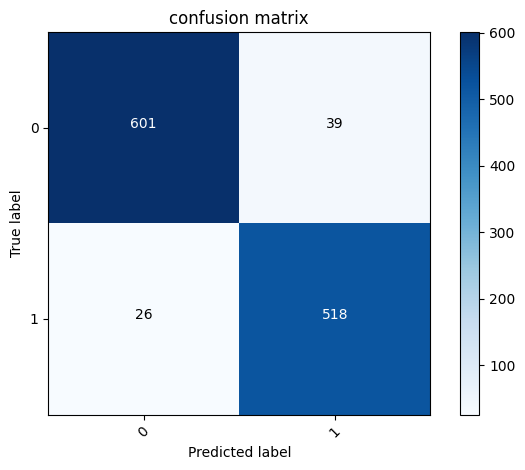

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
match my_model:
  case "AlexNet":
    model = AlexNet().to(device)
  case "TinyVGG":
    model = TinyVGG().to(device)
  case "ResIdentity":
    model = ResNet(3,1, [2,2,2,2]).to(device)
  case _:
    model = AlexNet().to(device)

print(f"\nModel {my_model} created | optimizer: {my_optimizer} | learning rate: {learning_rate}")

# here we load our already pretrained models
model = loadModel(f'{my_model}_{my_optimizer}_{learning_rate}')
pic_path = f"pics/{my_model}_{my_optimizer}_{learning_rate}.png"
# now we test it
y_preds, y_tests, test_results = test_fn(model, my_model, test_dataloader, nn.BCEWithLogitsLoss(), test_results)

# use predictions to plot confusion matrix
test_ReportResults(y_preds, y_tests, pic_path=pic_path, cnf_plot=True)

files.download(pic_path)

## 5.3.  Make a structured table using the dictionary that we obtain in the last cell.

In [ ]:
# DataFrame of results
# Create a list to hold rows
rows = []

# Parse the dictionary keys and values
for key, value in test_results.items():
    parts = key.split('_')
    metric = parts[0]
    model = parts[1]
    learning_rate = parts[2]

    # Find the corresponding row or create a new one
    row = next((row for row in rows if row['Model'] == model and row['Learning rate'] == learning_rate), None)
    if not row:
        row = {'Model': model, 'Learning rate': learning_rate}
        rows.append(row)

    # Assign the value to the appropriate column
    if metric == 'testloss':
        row['Test Loss'] = value
    elif metric == 'testZOL':
        row['Test ZOL'] = value
    elif metric == 'testacc':
        row['Test acc'] = value

# Convert the rows to a DataFrame
test_df = pd.DataFrame(rows, columns=['Model', 'Learning rate', 'Test Loss', 'Test ZOL', 'Test acc'])

# make a csv
filename = f"results/test_result_{my_model}_{my_optimizer}_{learning_rate}.csv"
test_df.to_csv(filename, index=False)
files.download(filename)

# Display the DataFrame
test_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Model,Learning rate,Test Loss,Test ZOL,Test acc
0,AlexNet,0.001,0.222621,0.054899,94.510135
